# Regional variability of photoreceptor rhabdomere volume

- DRA/NDRA comparison 

In [1]:
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import sys
from cx_analysis.utils import yymmdd_today
from cx_analysis.dataframe_tools import assemble_cxvectors, extract_connector_table
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm
from cx_analysis.vis.hex_lattice import hexplot

In [2]:
cell_cm = subtype_cm()
plt.style.use('../cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module
### SAVE FIGS? ###
savefigs=False
fig_path = os.path.expanduser(f'~/Figures/{yymmdd_today()}_')
##################
##################
# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.png')

In [3]:
# Load/organize lamina connectome data
tp = '210809'
data_path = "Data/"

microvilli = pd.read_csv(f'Data/{tp}_lamina/microvilli-angle-conv.csv')
display(microvilli)

,Unnamed: 0,om,subtype,z-index,angle,conv-angle
0,630,A0,R1,-3255.0,1.1,0.019199
1,631,A0,R1,-3102.0,14.7,0.256563
2,632,A0,R1,-2949.0,3.9,0.068068
3,633,A0,R1,-2796.0,31.6,0.551524
4,634,A0,R1,-2643.0,36.9,0.644026
...,...,...,...,...,...,...
2614,535,E7,R8,2397.0,56.4,0.984366
2615,536,E7,R8,2469.0,42.4,0.740020
2616,537,E7,R8,2541.0,42.4,0.740020
2617,538,E7,R8,2613.0,50.8,0.886627


In [4]:
# Volume data from excel provided by AM. 
# Contains both the volume of each PR's cell body, and the volume of just their rhabdomeres
xl_path = data_path + 'cell_rbd_volume.xlsx'
parsed_xl = pd.read_excel(xl_path, header=[0, 1], index_col=0, nrows=9)
# Currently we only want the rhabdom volumes, so remove cell body columns
data = dict.fromkeys(parsed_xl.columns.levels[0])
for om in parsed_xl.columns.levels[0]:
    data[om] = parsed_xl.loc[:, (om, 'rbd')]

vol_df = pd.DataFrame(data)
vol_df = vol_df.rename(mapper={"R7'": "R7p"}, axis=0).rename(mapper={"E5*": "E5"}, axis=1).T
vol_df.index = vol_df.index.rename('om')
vol_df.sort_values(by='om')

total_vol = vol_df.sum(axis=1)
frac_vol = (vol_df.T / total_vol).T

# Load/organize lamina connectome data
link_df = pd.read_pickle(data_path + f"{tp}_linkdf.pickle")
assert('UNKNOWN' not in link_df['post_type'])  # these should already be removed in preprocessing
cxvecs = assemble_cxvectors(link_df).astype(float)

In [5]:
display(pd.DataFrame({'mean': frac_vol.mean(), 'sd': frac_vol.std(ddof=0)}))

,mean,sd
R1,0.078493,0.018374
R2,0.120635,0.023697
R3,0.075578,0.022672
R7p,0.222018,0.050407
R4,0.073087,0.017676
R5,0.125476,0.016688
R6,0.067120,0.015494
R7,0.138310,0.054618
R8,0.099282,0.046250


## Relationship between total syn outputs and total rhabdom volume
- Limited eye space is unequally distributed between ommatidia. Hypothesis: ommatidia with larger rhabdoms have more synapses in the lamina cause of increased SNR

In [6]:
display(total_vol.mean())
display(total_vol.std())
display(total_vol.sort_values(0))
display(total_vol.sort_values(0).index)

40.99861596910346

15.378955115201537

om
B6    17.350772
E7    19.070826
D7    19.240500
C6    20.604480
A5    20.781313
D6    21.316027
B5    22.299462
E6    27.709432
C5    27.962347
A4    32.712863
E5    33.311810
D5    40.378816
D4    42.181802
E4    42.359515
C4    43.402358
A3    44.923156
B4    47.024777
D2    47.881123
D3    48.018025
A0    49.543530
B3    50.655896
C3    51.106389
C1    53.784661
A2    55.745723
A1    57.566297
B0    58.856325
B2    60.126427
C2    65.202691
B1    67.842520
dtype: float64

Index(['B6', 'E7', 'D7', 'C6', 'A5', 'D6', 'B5', 'E6', 'C5', 'A4', 'E5', 'D5',
       'D4', 'E4', 'C4', 'A3', 'B4', 'D2', 'D3', 'A0', 'B3', 'C3', 'C1', 'A2',
       'A1', 'B0', 'B2', 'C2', 'B1'],
      dtype='object', name='om')

## Rhabdomere volume of PR subtypes vs. overall rhabdom volume

In [7]:
rnums = [r.split('_')[0] for r in vol_df.columns.unique()]

rtypes = ['R_quartet', 'R_duet', 'R7', 'R8', 'R7p']
svfs = ('R1', 'R2', 'R3', 'R4', 'R5', 'R6')
lvfs = ('R7', 'R8', "R7p")

m_style = dict([(rt, 'o') for rt in svfs])
m_style.update({'R7': 'x', 'R8': 'v', 'R7p': 'D'})
ommatidia = vol_df.index.unique()
display(m_style.items())

ct_df = extract_connector_table(link_df) # DataFrame of connectors (presyn terminals)

dict_items([('R1', 'o'), ('R2', 'o'), ('R3', 'o'), ('R4', 'o'), ('R5', 'o'), ('R6', 'o'), ('R7', 'x'), ('R8', 'v'), ('R7p', 'D')])

Text(0, 0.5, 'Rhabdom volume ($\\mu{m}^{3}$)')

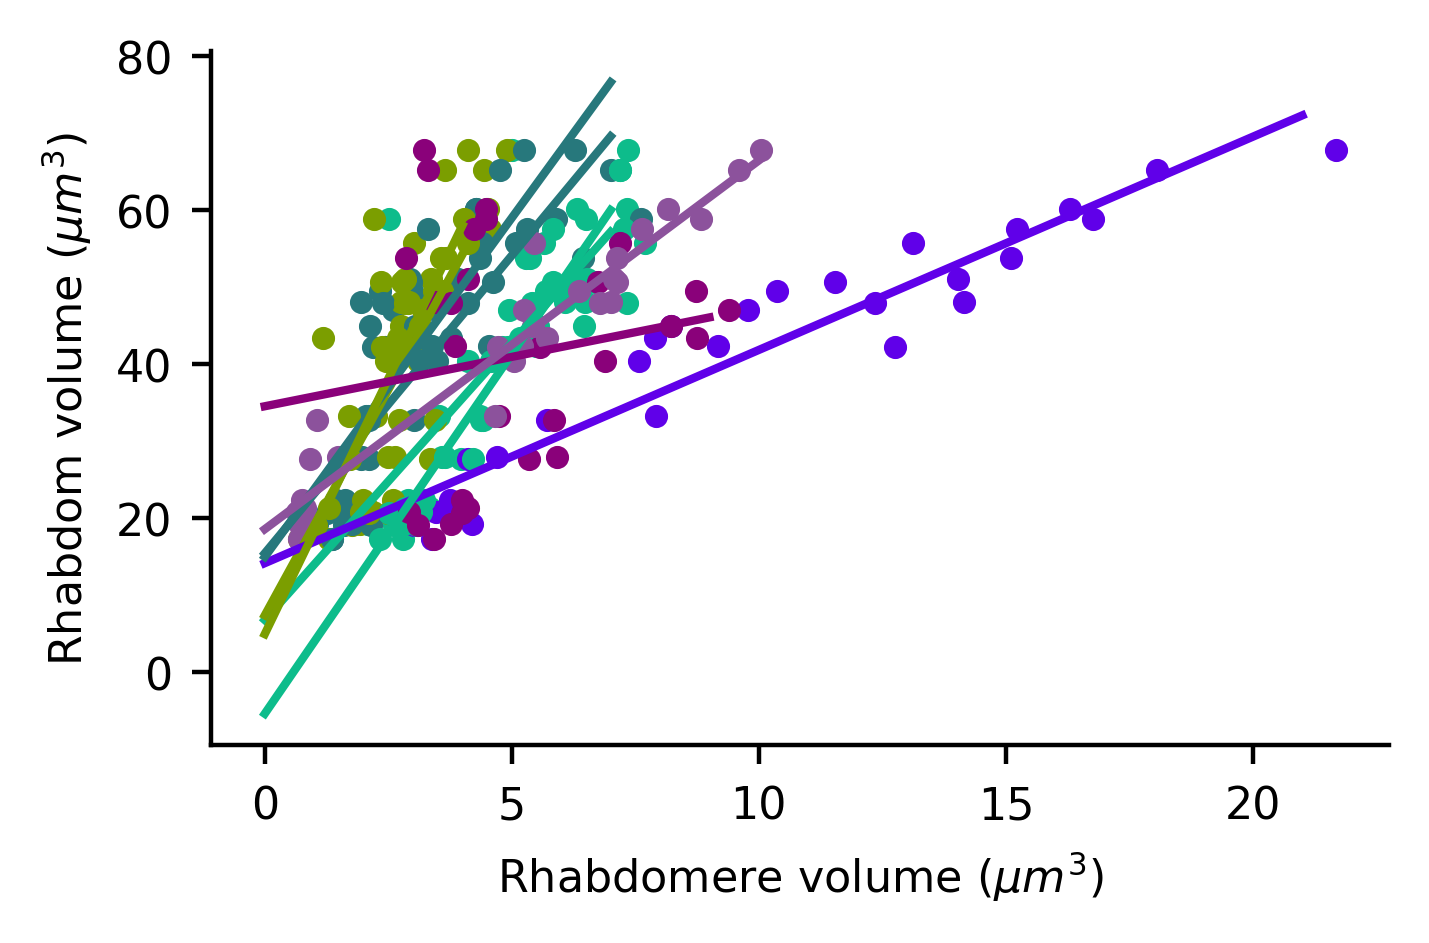

In [8]:
fig, ax = plt.subplots(1) 
for this_rtype, vol in vol_df.iteritems():
#     if this_rtype == 'R_quartet':
#         _x = pd.Series(vol_df.loc[''])
#     if this_rtype in ['R7', 'R8', 'R7p']:
#         continue
    Y = total_vol
    _x = vol_df[this_rtype]
    X = sm.add_constant(_x)

    model = sm.OLS(Y, X)
    results = model.fit()
    params = results.params
    #display(results.summary())

    # raw data scatter
    ax.scatter(x=_x, y=Y, c=cell_cm[this_rtype], label=this_rtype, s=10)

    xx = np.arange(0, max(_x))
    ax.plot(xx, params['const'] + params[this_rtype] * xx, c=cell_cm[this_rtype])
ax.set_xlabel('Rhabdomere volume ($\mu{m}^{3}$)')
ax.set_ylabel('Rhabdom volume ($\mu{m}^{3}$)')
        
        

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     152.4
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           1.79e-25
Time:                        12:44:48   Log-Likelihood:                -280.58
No. Observations:                 174   AIC:                             565.2
Df Residuals:                     172   BIC:                             571.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4961      0.268      1.854      0.065      -0.032       1.024
x1             0.0756      0.006     12.343      0.000       0.063       0.088
==============================================================================
Omnibus:                        6.717   Durbin-Watson:                   2.703
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                5.633
Skew:                           0.351   Prob(JB):                       0.0598
Kurtosis:                       2.468   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'######R7p#######'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     291.8
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           5.32e-16
Time:                        12:44:48   Log-Likelihood:                -53.280
No. Observations:                  29   AIC:                             110.6
Df Residuals:                      27   BIC:                             113.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8564      0.845     -4.561      0.000      -5.591      -2.122
x1             0.3305      0.019     17.083      0.000       0.291       0.370
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   1.544
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.669
Skew:                          -0.007   Prob(JB):                        0.716
Kurtosis:                       2.256   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'######R7#######'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.7119
Date:                Thu, 13 Jan 2022   Prob (F-statistic):              0.406
Time:                        12:44:48   Log-Likelihood:                -59.219
No. Observations:                  29   AIC:                             122.4
Df Residuals:                      27   BIC:                             125.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2269      1.038      4.074      0.000       2.098       6.356
x1             0.0200      0.024      0.844      0.406      -0.029       0.069
==============================================================================
Omnibus:                        3.721   Durbin-Watson:                   1.400
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                3.313
Skew:                           0.798   Prob(JB):                        0.191
Kurtosis:                       2.562   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'######R8#######'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     409.6
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           7.54e-18
Time:                        12:44:48   Log-Likelihood:                -33.194
No. Observations:                  29   AIC:                             70.39
Df Residuals:                      27   BIC:                             73.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3470      0.423     -7.913      0.000      -4.215      -2.479
x1             0.1959      0.010     20.239      0.000       0.176       0.216
==============================================================================
Omnibus:                       10.314   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.038
Skew:                          -1.096   Prob(JB):                       0.0109
Kurtosis:                       4.636   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

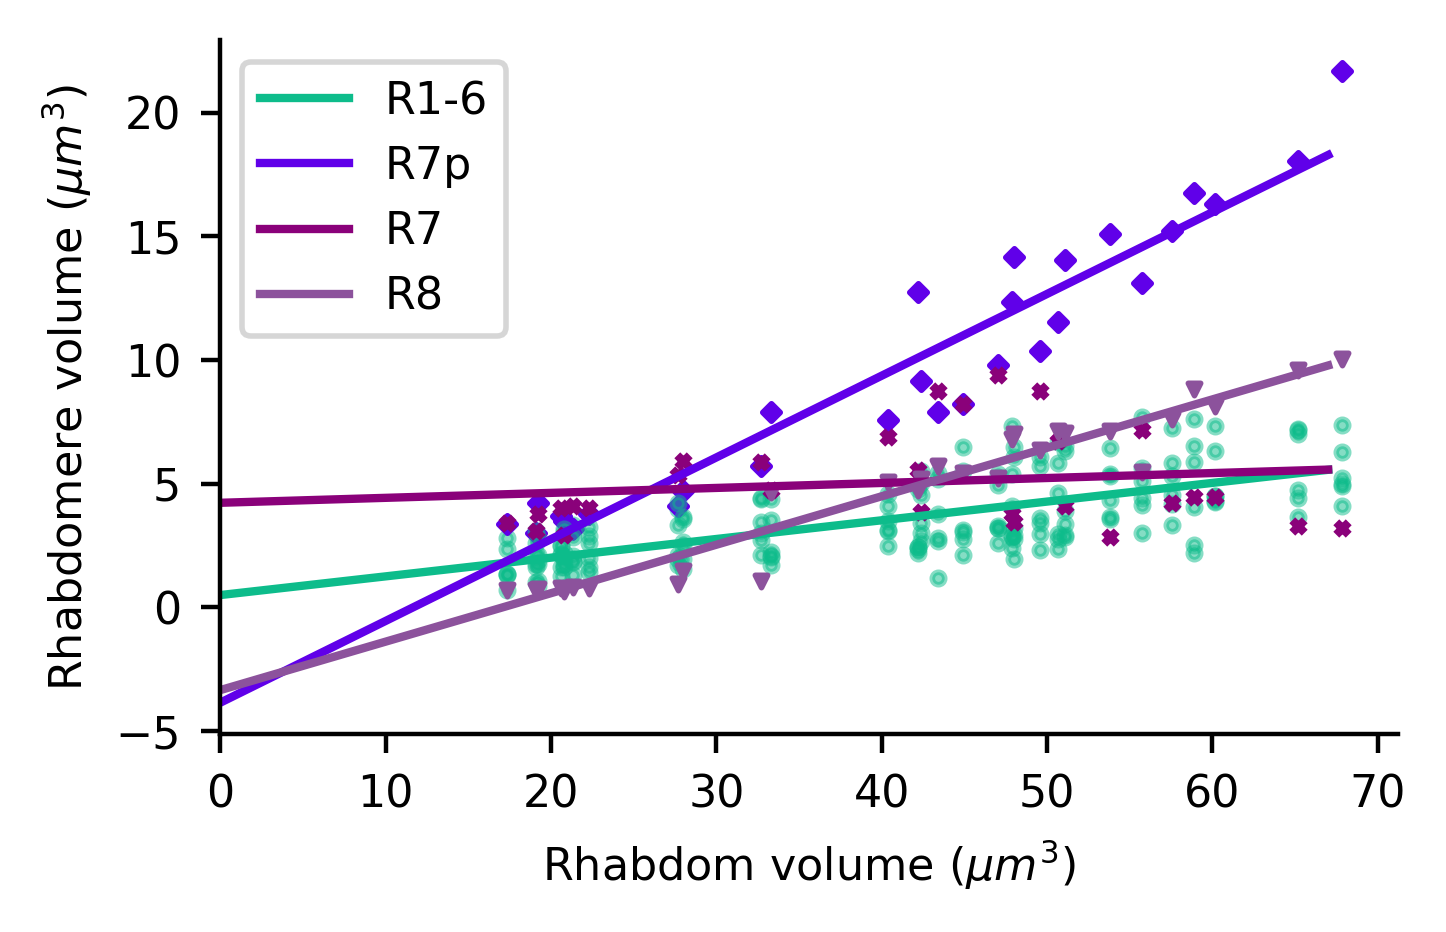

In [9]:
fig, ax = plt.subplots(1) 

# R1-6
#XY = pd.DataFrame([vol_df[:, svf].melt().value(), total_vol.repeat(29)])
assert(all(total_vol.index == vol_df.index))
_x = np.repeat(total_vol.to_numpy(), 6)
X = sm.add_constant(_x)
Y = vol_df.loc[:, svfs].to_numpy().flatten()

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

xx = np.arange(0, max(_x))
ax.plot(xx, params[0] + params[1] * xx, c=cell_cm['R_duet'], label='R1-6')

for this_rtype, vol in vol_df.iteritems():
#     if this_rtype == 'R_quartet':
#         _x = pd.Series(vol_df.loc[''])
#     if this_rtype in ['R7', 'R8', 'R7p']:
#         continue
    _x = total_vol.to_numpy()
    Y = vol_df[this_rtype].to_numpy()
    if this_rtype in lvfs:
        
        
        X = sm.add_constant(_x)
        

        model = sm.OLS(Y, X)
        results = model.fit()
        params = results.params
        display(f'######{this_rtype}#######')
        display(results.summary())
        xx = np.arange(0, max(_x))
        this_c = cell_cm[this_rtype]
        this_a = 1.0
        ax.plot(xx, params[0] + params[1] * xx, c=cell_cm[this_rtype], label=this_rtype)
    else:
        this_c = cell_cm['R_duet']
        this_a = 0.5
        
    # raw data scatter
    ax.scatter(x=_x, y=Y, c=this_c, alpha=this_a, s=5, marker=m_style[this_rtype])
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_xlabel('Rhabdom volume ($\mu{m}^{3}$)')
ax.set_ylabel('Rhabdomere volume ($\mu{m}^{3}$)')

ax.legend()
        

,om,rtype,lamina_inputs,rb_vol,rb_fvol
0,A0,R7,34.0,8.727351,0.176155
1,A0,R8,26.0,6.358027,0.128332
2,A0,R7p,28.0,10.366335,0.209237
3,A1,R7,65.0,4.226182,0.073414
4,A1,R8,19.0,7.634705,0.132625
...,...,...,...,...,...
82,E6,R8,14.0,0.924302,0.033357
83,E6,R7p,42.0,4.115075,0.148508
84,E7,R7,48.0,3.101124,0.162611
85,E7,R8,10.0,0.718379,0.037669


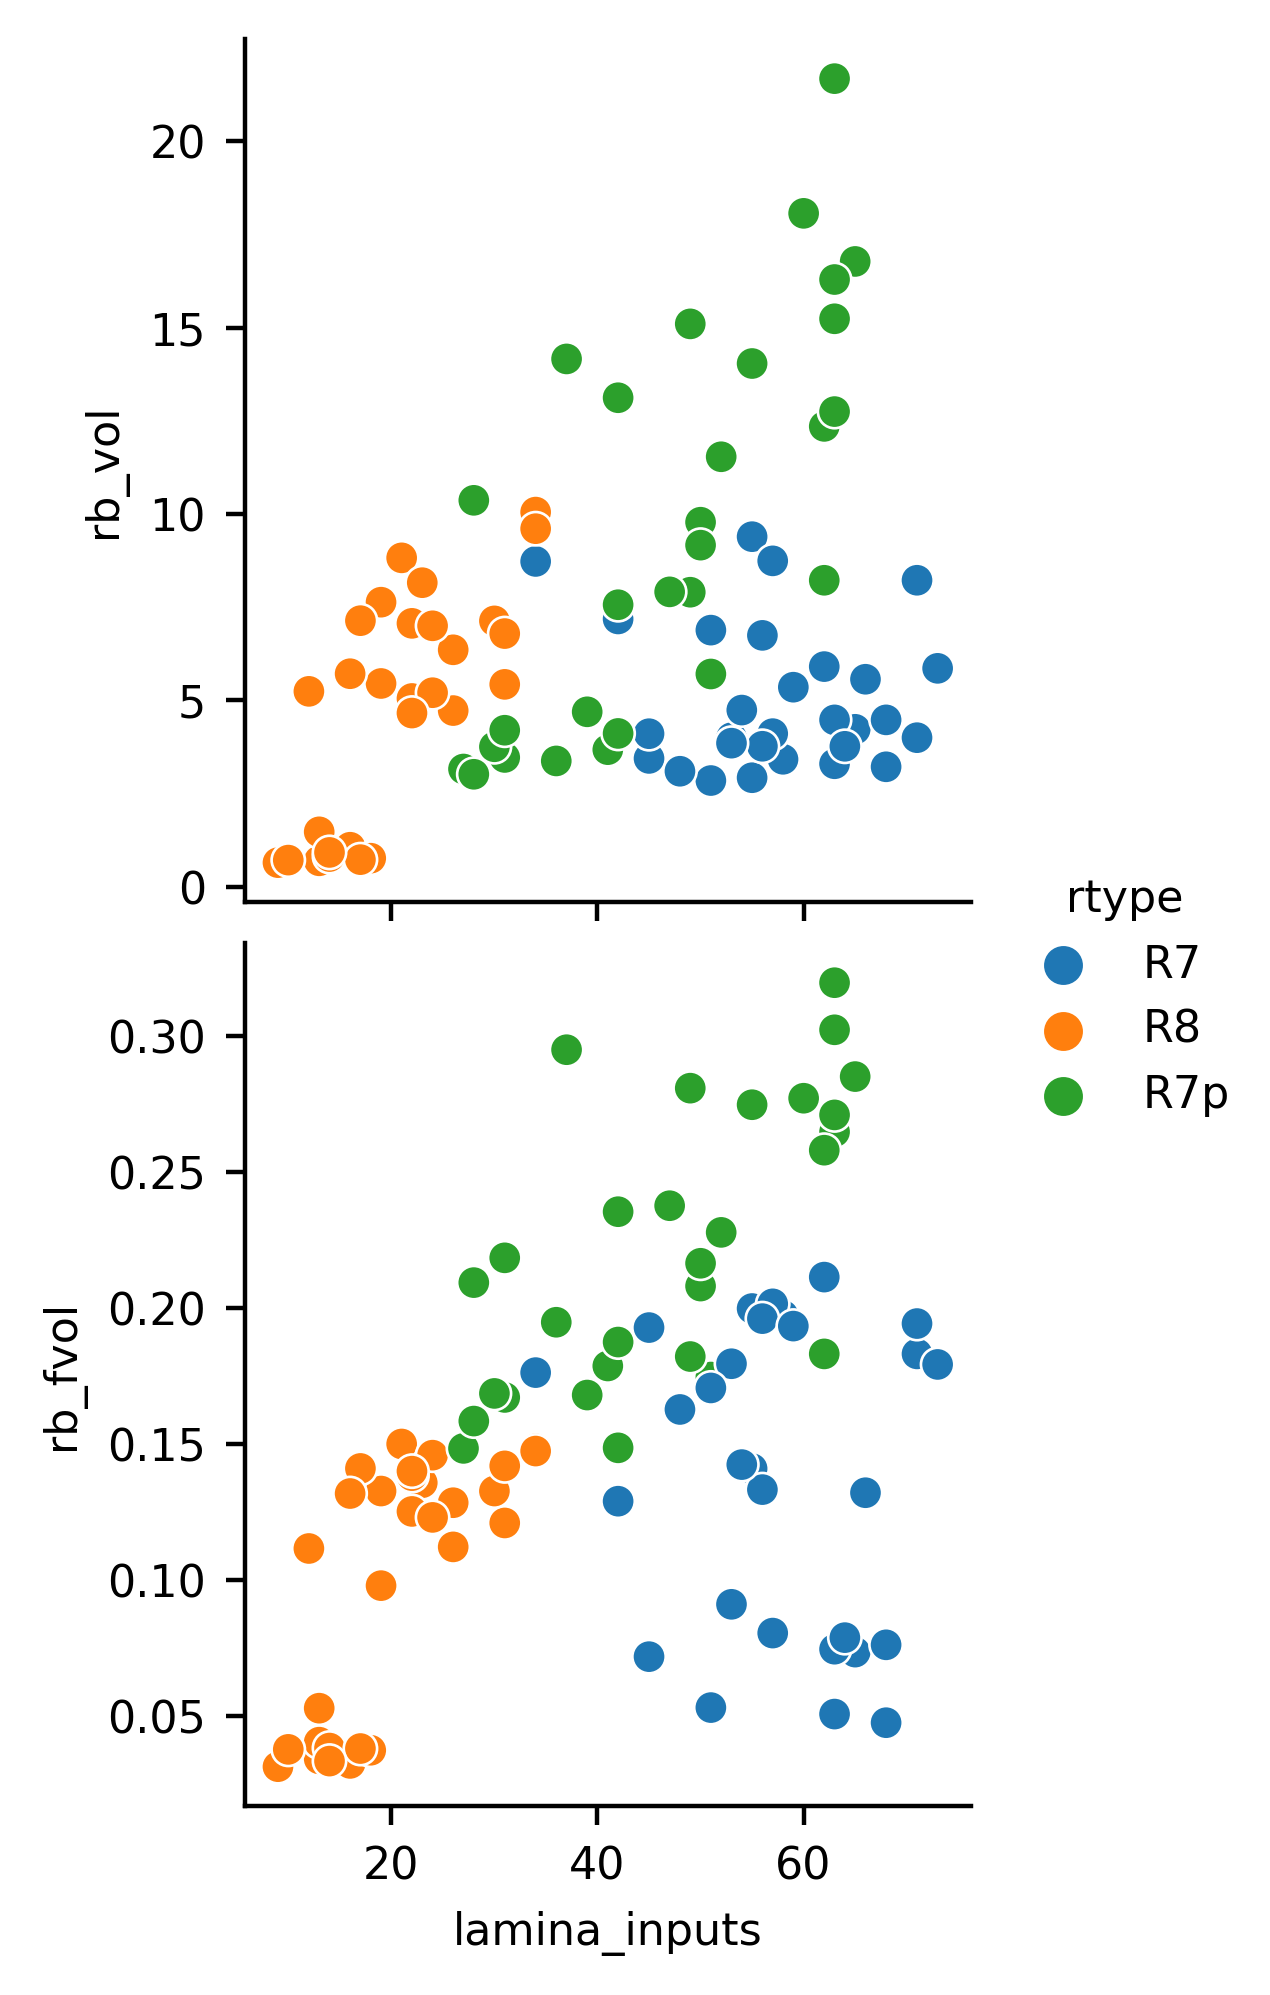

In [10]:
data = []

for om in ommatidia:
    for lvf in ['R7', 'R8', 'R7p']:

        this_inputs = cxvecs.loc[om].filter(like=f'->{lvf}').sum()
        
        this_data = {'om': om, 
                     'rtype': lvf, 
                     'lamina_inputs': this_inputs, 
                     'rb_vol': vol_df.loc[om, lvf], 
                     'rb_fvol': frac_vol.loc[om, lvf]}
        data.append(this_data)
#display(data)
combined = pd.DataFrame.from_records(data)
#combined['']
display(combined)

sns.pairplot(data=combined, hue='rtype', x_vars=['lamina_inputs'], y_vars=['rb_vol', 'rb_fvol'])

,om,rtype,lamina_inputs,rb_vol,rb_fvol
0,A0,R7,34.0,8.727351,0.176155
1,A0,R8,26.0,6.358027,0.128332
2,A0,R7p,28.0,10.366335,0.209237
3,A1,R7,65.0,4.226182,0.073414
4,A1,R8,19.0,7.634705,0.132625
...,...,...,...,...,...
82,E6,R8,14.0,0.924302,0.033357
83,E6,R7p,42.0,4.115075,0.148508
84,E7,R7,48.0,3.101124,0.162611
85,E7,R8,10.0,0.718379,0.037669


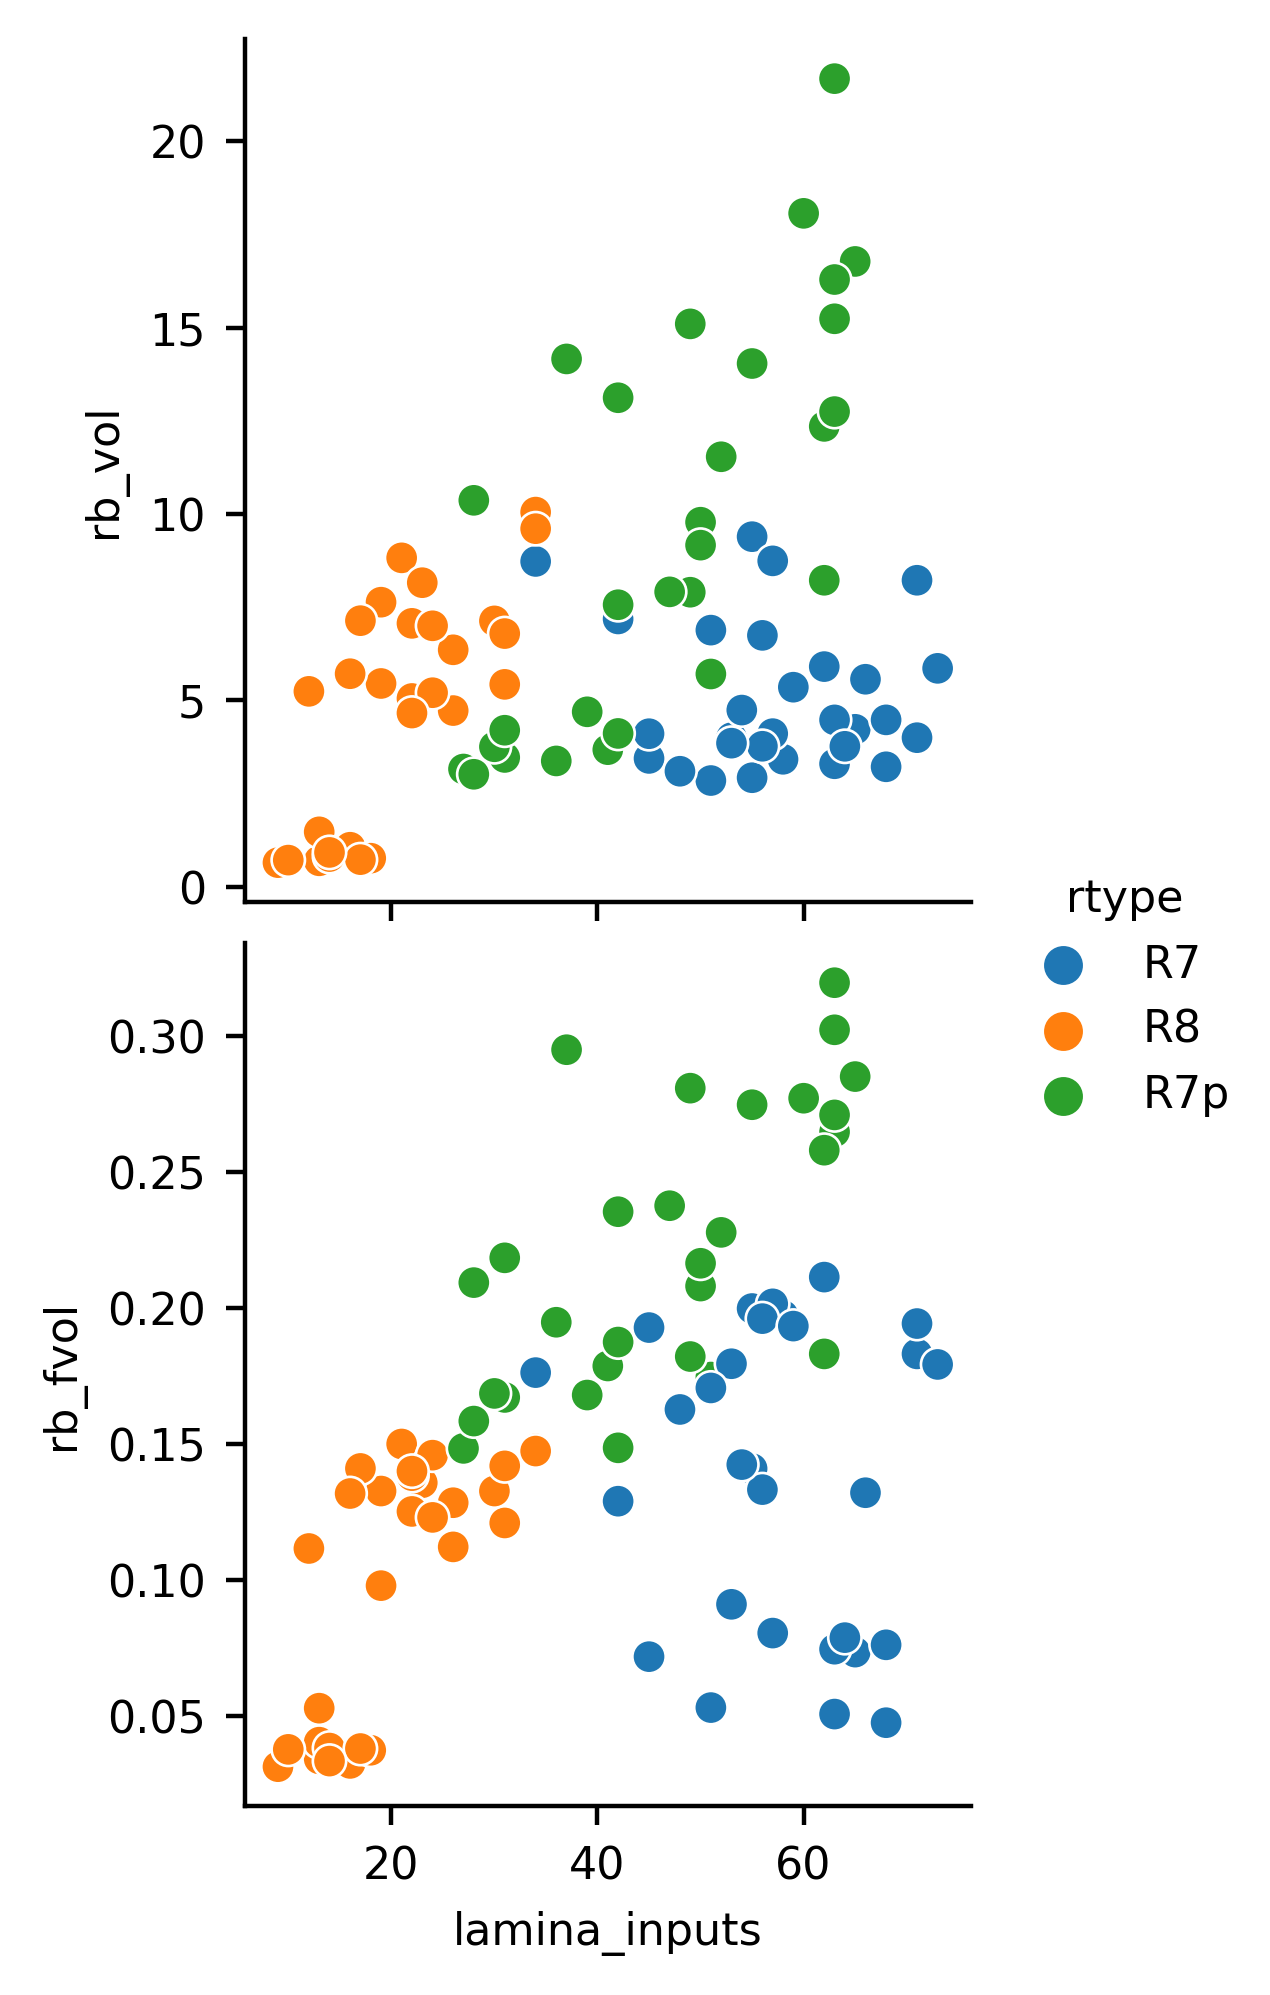

In [11]:
data = []

for om in ommatidia:
    for lvf in ['R7', 'R8', 'R7p']:

        this_inputs = cxvecs.loc[om].filter(like=f'->{lvf}').sum()
        
        this_data = {'om': om, 
                     'rtype': lvf, 
                     'lamina_inputs': this_inputs, 
                     'rb_vol': vol_df.loc[om, lvf], 
                     'rb_fvol': frac_vol.loc[om, lvf]}
        data.append(this_data)
#display(data)
combined = pd.DataFrame.from_records(data)
#combined['']
display(combined)

sns.pairplot(data=combined, hue='rtype', x_vars=['lamina_inputs'], y_vars=['rb_vol', 'rb_fvol'])

In [34]:
# We are interested in both the number of contacts and the number of terminals 
n_terminals = {om: dict.fromkeys(rtypes) for om in ommatidia}
n_contacts = {om: dict.fromkeys(rtypes) for om in ommatidia}
n_outs = link_df['pre_neuron'].value_counts().to_dict() # count of links associated with every neuron

# Filter out non-short PR contacts/terminals
# TODO: helper function to add column for sub sub type (e.g. 'R1' instead of R1R4)
# This can be done from link_df, TODO: MAKE MORE GENERAL AND PUT IN DATAFRAME TOOLS
for pre_name, these_rows in ct_df.groupby('pre_neuron'):
    
    # using our neuron name pattern to get ommatidium/rtypes of indv photoreceptors
    if pre_name[0:2] == 'om' and pre_name[5] == 'R':  
        #if len(pre_name) 
        om = pre_name[2: 4]
        r = pre_name.split('_')[1]
        assert(len(r) in (2, 3))
        n_terminals[om][r] = len(these_rows)
        n_contacts[om][r] = n_outs.get(pre_name, 0)
    else:
        continue

terms = pd.DataFrame(n_terminals).fillna(0).astype(int).T
ctx = pd.DataFrame(n_contacts).fillna(0).astype(int).T

terms.index.name = 'om'
ctx.index.name = 'om'

terms = terms.sort_values(by='om')
ctx = ctx.sort_values(by='om')

frac_ctx = (ctx.T/ctx.sum(axis=1)).T

In [35]:
svfs = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']
lvfs = ['R7', 'R8', 'R7p']

### Lamina connectivity data
- Before computing correlation, filter out: interommatidial connections, and connections with mean count < 1.0
- Should connections associated with L4, the only cell not present in every ommatidium, be filtered out? (keep for now)

In [36]:
display(f"Number of connections observed (all): {len(cxvecs.columns)}")
mean_thresh = 1.0
cxvecs = cxvecs.loc[:, cxvecs.mean() >= mean_thresh]
display(f"Number of connections observed (where mean count >= {mean_thresh}): {len(cxvecs.columns)}")

only_home_connections = True
if only_home_connections:
    cxvecs = cxvecs.loc[:, [i for i in cxvecs.columns if ('eLMC_4' not in i) and ('eLMC_2' not in i)]]
display(f"Number of connections after removing inter-ommatidial: {len(cxvecs.columns)}")

'Number of connections observed (all): 136'

'Number of connections observed (where mean count >= 0.5): 52'

'Number of connections after removing inter-ommatidial: 46'

## Rhabdomere volumes by subtype
- Long photoreceptor subtypes generally form larger rhabdomeres
- The smallest rhabdomeres belong to photoreceptor pairs R1&R4 and R3&R6

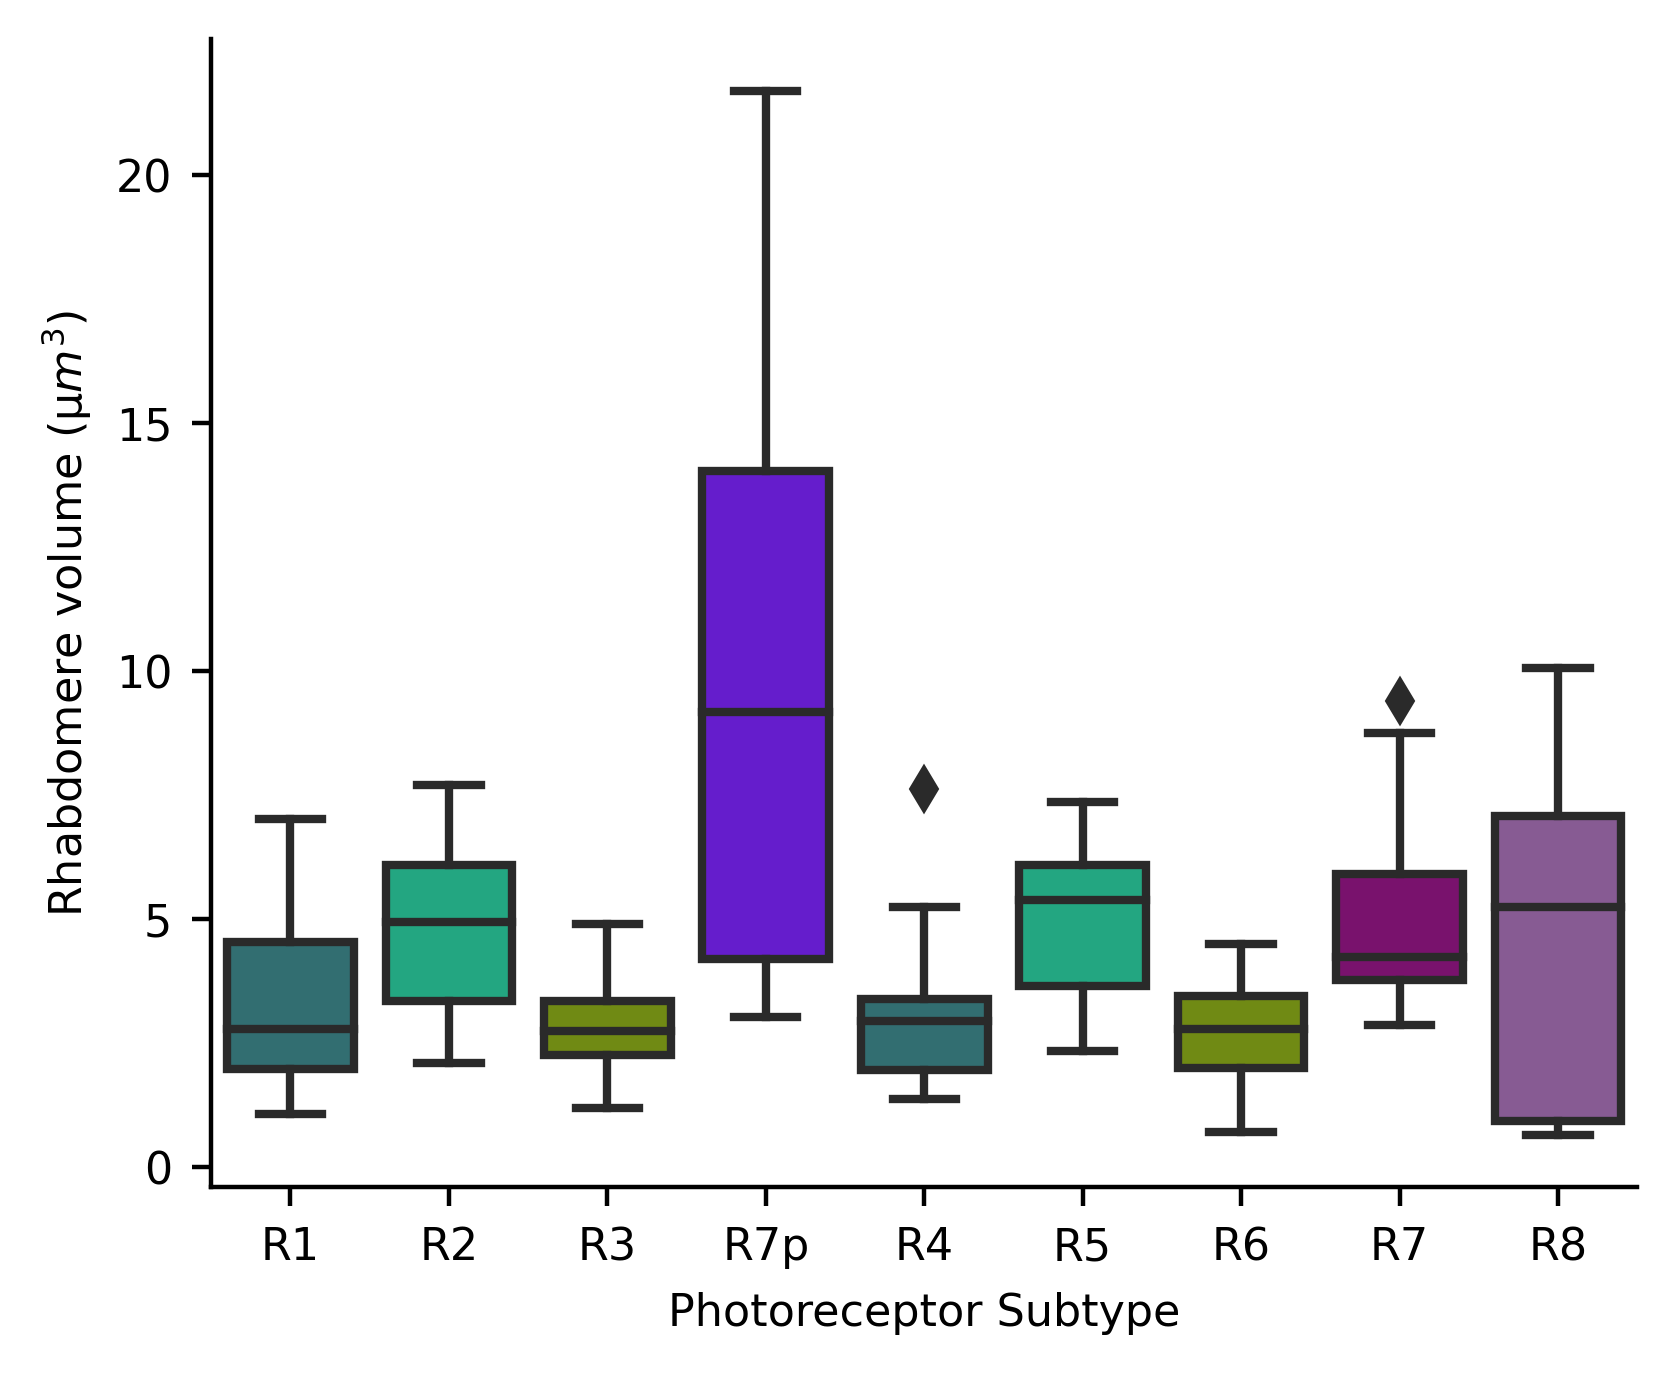

In [38]:
fig, ax = plt.subplots(1, figsize=[4.6, 3.8])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
overall_max = vol_df.max().max()
cm = subtype_cm()

sts = [l.split('_')[0] for l in vol_df.columns]
hues = [cm[c] for c in sts]

#subtypes = sorted(subtypes)
ax = sns.boxplot(data=vol_df, palette=hues)
ax.set_xticklabels([l.split('_')[0] for l in vol_df.columns])
ax.set_xlabel('Photoreceptor Subtype')
ax.set_ylabel('Rhabdomere volume (\u03BC$m^3$)')


plt.show()
if savefigs:
    fig.savefig(fig_path + 'rhab_vol_box.svg')
    fig.savefig(fig_path + 'rhab_vol_box.png')


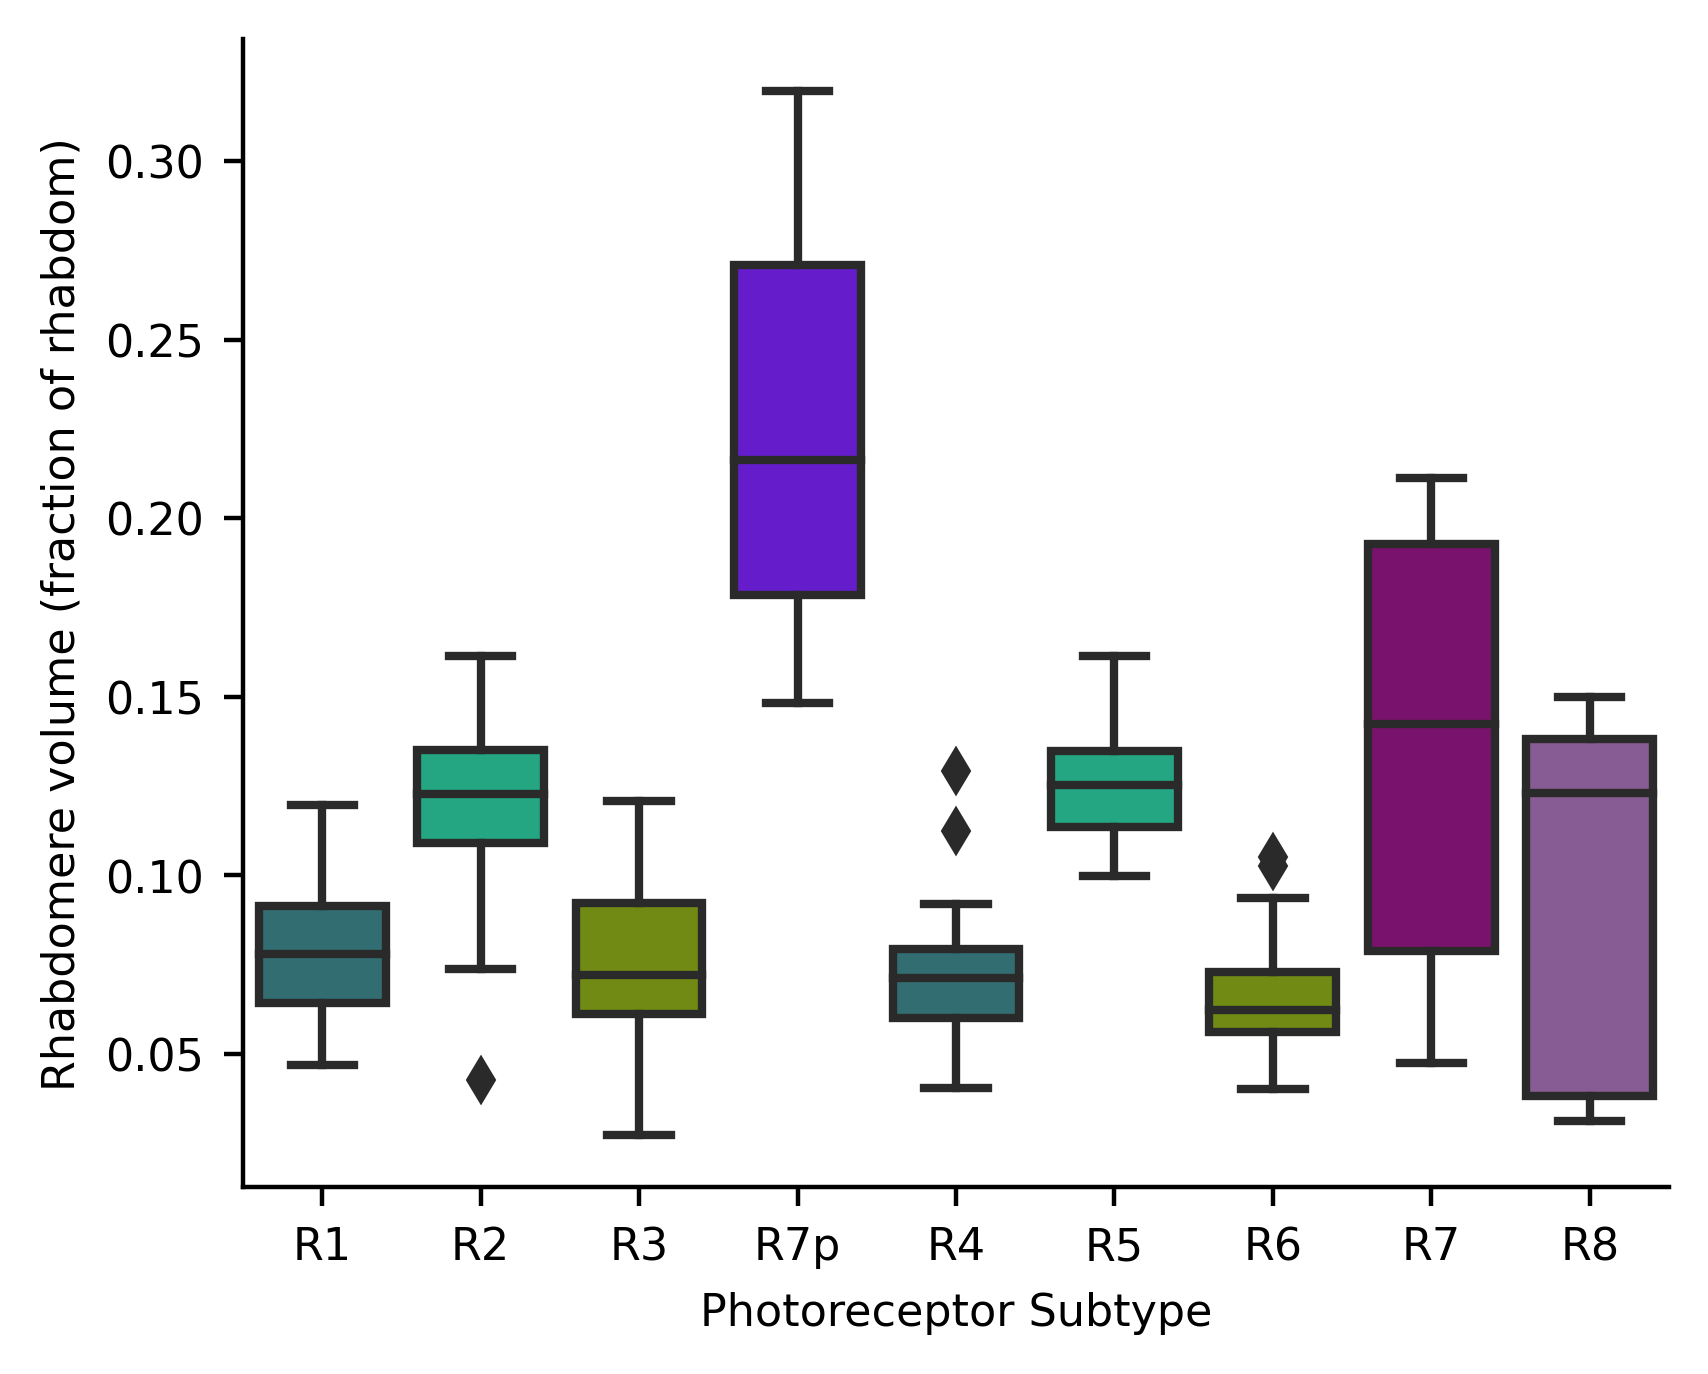

In [17]:
fig, ax = plt.subplots(1, figsize=[4.6, 3.8])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
overall_max = frac_vol.max().max()
cm = subtype_cm()

sts = [l.split('_')[0] for l in frac_vol.columns]
hues = [cm[c] for c in sts]

#subtypes = sorted(subtypes)
ax = sns.boxplot(data=frac_vol, palette=hues)
ax.set_xticklabels([l.split('_')[0] for l in vol_df.columns])
ax.set_xlabel('Photoreceptor Subtype')
ax.set_ylabel('Rhabdomere volume (fraction of rhabdom)')


plt.show()
if savefigs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/rhab_fracvol_box.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/rhab_fracvol_box.png')


In [16]:
display(frac_vol[svfs].melt().mean())
display(frac_vol[svfs].melt().std(ddof=0))

value    0.090065
dtype: float64

value    0.030526
dtype: float64

In [17]:
display(frac_vol[lvfs].melt().mean())
display(frac_vol[lvfs].melt().std(ddof=0))

value    0.153203
dtype: float64

value    0.071944
dtype: float64

<ipython-input-18-87d9643d2742>:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie(frac_vol.melt().mean())


([<matplotlib.patches.Wedge at 0x7feee0a74280>],
 [Text(1.0336618818860421, 0.3762221603465248, '')])

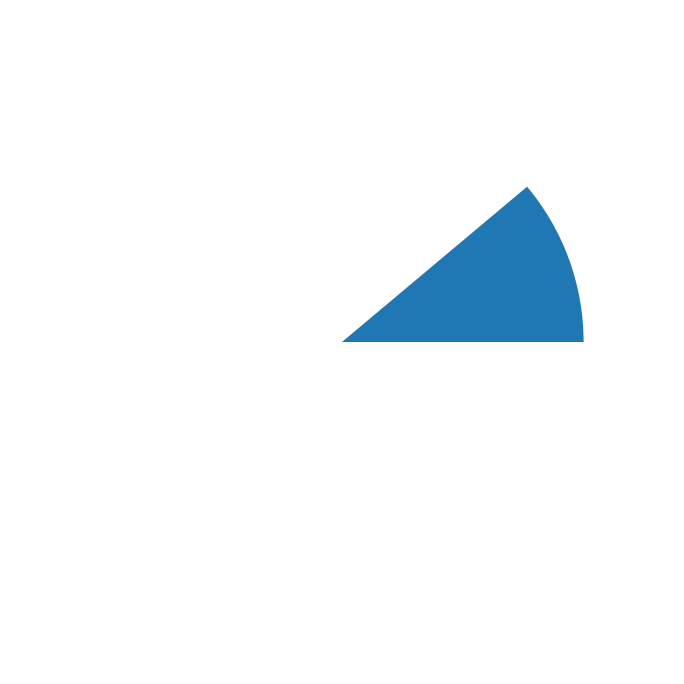

In [18]:
fig, ax = plt.subplots(1, figsize=[2, 2])

ax.pie(frac_vol.melt().mean())

In [ ]:
display(frac_vol['R7p'])
for om in ommatidia:
    if frac_vol.loc[om, 'R7p'] < frac_vol.loc[om].max():
        display(om)
    


## Total rhabdom volume varies considerably
- R1-6 and R7' rhabdomere volumes follow closely with total rhabdom volume
- R7 and R8 vary according to retinotopic position

In [ ]:
fig, ax = plt.subplots(1)
cm = linear_cmap(100, st_cm['LMC_1'])

total_vol = vol_df.sum(axis=1).rename('Total volume')
#display(total_vol)
max_total = total_vol.max()
node_data = dict.fromkeys(ommatidia)

for k, v in node_data.items():
    
    x = total_vol[k]
    node_data[k] = {"colour": cm(x/max_total),
                    "label": f"{x: .1f}"}

hexplot(node_data, ax=ax, scale_factor=0.05)
ax.set_title(f"Total rhabdom volume (\u03BC$m^3$)\n" + 
             f"Mean: {total_vol.mean(): .1f}\n" +
             f"SD = {total_vol.std(): .1f}\n")
             

In [ ]:
fig, ax = plt.subplots(1)
total_range = total_syn.max() - total_syn.min()

node_data = dict.fromkeys(ommatidia)
for k, v in node_data.items():
    x = total_syn[k]
    node_data[k] = {"colour": cm((x-total_syn.min())/total_range),
                    "label": f"{x: .0f}"}
hexplot(node_data, ax=ax, scale_factor=0.05)
ax.set_title(f"Total synaptic connections\n" + 
             f"Mean: {total_syn.mean(): .0f}\n" +
             f"SD = {total_syn.std(): .0f}\n")
             

## R1-6 rhabdomere volumes correlate with the the number of output synapses they form in the lamina

In [ ]:
X = vol_df.loc[:, svfs].values.flatten()
X = sm.add_constant(X)

Y = ctx.loc[:, svfs].values.flatten()

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

In [ ]:
fig, ax = plt.subplots(1)

pairs = [['R1', 'R4'], ['R2', 'R5'], ['R3', 'R6']]
markers = ('o', '+', '^')

for p, m in zip(pairs, markers):
    display(p)
    st_label = p[0] + p[1] # e.g. 'R1R4'
    
    _x = vol_df.loc[:, p].values.flatten()
    X = sm.add_constant(_x)

    Y = ctx.loc[:, p].values.flatten()
    
    model = sm.OLS(Y, X)
    results = model.fit()
    display(results.summary())
    params = results.params
    
    display(params)
    
    #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
    ax.scatter(x=_x, y=Y, c=st_cm[st_label], marker=m, label=st_label)
    #ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
    ax.set_xlabel('Rhabdomere volume ($\mu{m}^3$)')
    ax.set_ylabel("# output synapses")

#xx = np.arange(min(_x), max(_x))
    xx = np.arange(0, max(_x))
    ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')
ax.legend()
plt.show()
    
    

In [ ]:
fig, ax = plt.subplots(1)

pairs = [['R1', 'R4'], ['R2', 'R5'], ['R3', 'R6']]
markers = ('o', '+', '^')

for p, m in zip(pairs, markers):
    display(p)
    st_label = p[0] + p[1] # e.g. 'R1R4'
    
    _x = frac_vol.loc[:, p].values.flatten()
    X = sm.add_constant(_x)

    Y = ctx.loc[:, p].values.flatten()
    
    model = sm.OLS(Y, X)
    results = model.fit()
    display(results.summary())
    params = results.params
    
    display(params)
    
    #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
    ax.scatter(x=_x, y=Y, c=st_cm[st_label], marker=m)
    #ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
    ax.set_xlabel('Fraction of rhabdom volume')
    ax.set_ylabel("# output synapses")

#xx = np.arange(min(_x), max(_x))
    xx = np.arange(0, max(_x))
    ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()
    
    

In [ ]:
fig, ax = plt.subplots(1)

pairs = [['R1', 'R4'], ['R2', 'R5'], ['R3', 'R6']]
markers = ('o', '+', '^')

for p, m in zip(pairs, markers):
    display(p)
    st_label = p[0] + p[1] # e.g. 'R1R4'
    
    _x = frac_vol.loc[:, p].values.flatten()
    X = sm.add_constant(_x)

    Y = frac_ctx.loc[:, p].values.flatten()
    
    model = sm.OLS(Y, X)
    results = model.fit()
    display(results.summary())
    params = results.params
    
    display(params)
    
    #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
    ax.scatter(x=_x, y=Y, c=st_cm[st_label], marker=m)
    #ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
    ax.set_xlabel('Fraction of rhabdom volume')
    ax.set_ylabel("Fraction of R1-6 output synapses")

#xx = np.arange(min(_x), max(_x))
    xx = np.arange(0, max(_x))
    ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()
    
    

In [ ]:
fig, ax = plt.subplots(1)

prs = ["R7", "R8", "R7p"]
markers = ('o', '+', '^')

for p, m in zip(prs, markers):
    display(p)
    st_label = p
    
    _x = frac_vol.loc[:, p].values.flatten()
    X = sm.add_constant(_x)

    Y = ctx.loc[:, p].values.flatten()
    
    model = sm.OLS(Y, X)
    results = model.fit()
    display(results.summary())
    params = results.params
    
    display(params)
    
    #ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
    ax.scatter(x=_x, y=Y, c=st_cm[st_label], marker=m)
    #ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
    ax.set_xlabel('Fraction of rhabdom volume')
    ax.set_ylabel("# output synapses")

#xx = np.arange(min(_x), max(_x))
    xx = np.arange(0, max(_x))
    ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()



In [ ]:
X = vol_df.loc[:, 'R1'] - vol_df.loc[:, 'R4']
X = sm.add_constant(X)

Y = ctx.loc[:, 'R1'] - ctx.loc[:, 'R4']

display(X)

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

In [ ]:
X = total_vol
X = sm.add_constant(X)
Y = spr_syn

model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())

In [ ]:
X = vol_df.filter(items = [v for v in vol_df.columns if int(v[1]) < 7]).sum(axis=1)
#display(X)
X = sm.add_constant(X)
Y = spr_syn



model = sm.OLS(Y, X)
results = model.fit()

display(results.summary())